# <center>EPIB 613 INTRODUCTION TO STATISTICAL SOFTWARE</center>

<center> McGill EBOH </center>

<center> Fall 2020 </center>

<center> Yi Lian </center>

# Lecture 12
- Generalized linear models
    - Logistic regression
    - Poisson regression

- Bootstrap
    - Motivation
    - Rationale
    - Example
    - Exercise

## 12.1 Generalized linear models
### 12.1.1 Logistic regression
- Used to model binary outcome
- More specifically, we model the logit function of the probability with a linear model
    - Such that we are mostly likely to observe the observed data
    - Therefore the name __generalized linear__ model
    - Maximum likelihood estimator (MLE)

#### Example: graduate school admission.
A simulated graduate school admission data.
- `admit`
    - 1: admitted
    - 0: rejected.
- `rank`
    - 1: from good undergraduate schools
    - 0: from not as good undergraduate schools.
- `gre`
- `gpa`

In [1]:
df <- read.csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
df$rank <- ceiling(df$rank/2) - 1
head(df)

,admit,gre,gpa,rank
,<int>,<int>,<dbl>,<dbl>
1,0,380,3.61,1
2,1,660,3.67,1
3,1,800,4.00,0
4,1,640,3.19,1
5,0,520,2.93,1
6,1,760,3.00,0


##### 1. Investigate the association between admit and rank in terms of odds ratio.

In [2]:
table(df[,c("rank", "admit")])[c(2,1),c(2,1)]

    admit
rank   1   0
   1  40 148
   0  87 125

In [3]:
OR <- 40*125/(87*148); OR

[1] 0.3883194

In [4]:
fit1 <- glm(admit~rank,
            family = binomial(link = "logit"),
            data = df)
summary(fit1)


Call:
glm(formula = admit ~ rank, family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0279  -1.0279  -0.6917   1.3347   1.7593  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.3624     0.1396  -2.596  0.00944 ** 
rank         -0.9459     0.2264  -4.178 2.94e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 481.66  on 398  degrees of freedom
AIC: 485.66

Number of Fisher Scoring iterations: 4


In [5]:
exp(fit1$coefficients)

(Intercept)        rank 
  0.6960000   0.3883194

In [6]:
# CI for the odds ratio
exp(confint(fit1, level = 0.95))

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.5279583,0.9134167
rank,0.2473729,0.6017864


In [7]:
# Prediction
# type = "response" gives the fitted probability
nd <- data.frame(rank = c(0,1))
predict(fit1, type = "response", newdata = nd)

1         2 
0.4103774 0.2127660

On average, the probability of admission for rank 0 is 0.41 and 0.21 for rank 1.

In [8]:
# type = "link" give the fitted linear predictor
predict(fit1, type = "link", newdata = nd)

1          2 
-0.3624056 -1.3083328

##### 2. Investigate the association between admit and GPA in terms of odds ratio.
GPA is continuous, therefore we can no longer make the 2x2 table to get the odds ratio.

Regression!

In [9]:
fit2 <- glm(admit~gpa,
            family = binomial(),
            data = df)
summary(fit2)
# the link function for binomial family is logit by default - canonical link


Call:
glm(formula = admit ~ gpa, family = binomial(), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1131  -0.8874  -0.7566   1.3305   1.9824  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.3576     1.0353  -4.209 2.57e-05 ***
gpa           1.0511     0.2989   3.517 0.000437 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 486.97  on 398  degrees of freedom
AIC: 490.97

Number of Fisher Scoring iterations: 4


In [10]:
fit2$coefficients

(Intercept)         gpa 
  -4.357587    1.051109

In [11]:
exp(fit2$coefficients)

(Intercept)         gpa 
 0.01280926  2.86082123

In [12]:
# Predict the probability of admit given 4.0 GPA
predict(fit2, newdata=data.frame(gpa=4), type="response")

1 
0.4617866

##### 3. Investigate the association between admit and all three variables.

In [13]:
fit3 <- glm(admit~., family = binomial(), data = df)
summary(fit3)


Call:
glm(formula = admit ~ ., family = binomial(), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4290  -0.8902  -0.6552   1.1937   2.1122  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.679673   1.100498  -4.252 2.12e-05 ***
gre          0.002280   0.001085   2.101  0.03568 *  
gpa          0.864058   0.327562   2.638  0.00834 ** 
rank        -0.938317   0.232946  -4.028 5.62e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 463.37  on 396  degrees of freedom
AIC: 471.37

Number of Fisher Scoring iterations: 3


### 12.1.2 Poisson regression
- Used to model count data
    - Poisson distribution is commonly used to model counts
        - Sometimes modeling the counts does not make sense
        - e.g. Number of accidents for a certain model of vehicle
    - Include an denominator to the counts to make a rate
        - e.g. Number of accidents for a certain model of vehicle per month
    
#### Example: Ship damage data
- `incidents`
    - Number of damage incidents during service
- `service`
    - Aggregate months of service
- `type`
    - 5 types of ships, A-E
- `year`
    - Year of construction

In [14]:
library(MASS)
ds <- ships
ds <- ds[ds$service>0, ]
head(ds)

,type,year,period,service,incidents
,<fct>,<int>,<int>,<int>,<int>
1,A,60,60,127,0
2,A,60,75,63,0
3,A,65,60,1095,3
4,A,65,75,1095,4
5,A,70,60,1512,6
6,A,70,75,3353,18


##### Investigate the association between rate of incidents and the variables

In [15]:
# The canonical link for poisson regression is log, so can be omitted.
fit.rate <- glm(incidents~type+as.factor(year)+offset(log(service)),
                family = poisson("log"), data = ds)
summary(fit.rate)


Call:
glm(formula = incidents ~ type + as.factor(year) + offset(log(service)), 
    family = poisson("log"), data = ds)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9538  -1.0525  -0.4846   0.5779   2.4183  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -6.26892    0.21241 -29.513  < 2e-16 ***
typeB             -0.55861    0.17767  -3.144  0.00167 ** 
typeC             -0.68388    0.32908  -2.078  0.03769 *  
typeD             -0.07032    0.29071  -0.242  0.80887    
typeE              0.30425    0.23581   1.290  0.19698    
as.factor(year)65  0.75347    0.14855   5.072 3.94e-07 ***
as.factor(year)70  0.96530    0.16369   5.897 3.70e-09 ***
as.factor(year)75  0.70828    0.22153   3.197  0.00139 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 146.328  on 33  degrees of freedom
Residual deviance:  49.355  on 26  degre

In [16]:
print(exp(fit.rate$coefficients))

      (Intercept)             typeB             typeC             typeD 
      0.001894267       0.572000831       0.504653459       0.932096489 
            typeE as.factor(year)65 as.factor(year)70 as.factor(year)75 
      1.355607592       2.124369011       2.625565697       2.030490911 


## 12.2 Bootstrap
### Motivation
Sometimes we cannot find the standard error thus the confidence interval of an estimator analytically.

We have learned from the statistics class that $\mathrm{Var}(aX+bY) = a^2\mathrm{Var}(X)+b^2\mathrm{Var}(Y)$

What about $\mathrm{Var}(XY)$ or $\mathrm{Var}(X/Y)$

### Rationale

1. Resample from our dataset with replacement for many many many times.

2. Perform the same estimation for each sample.

3. Acquire an empirical confidence interval.

### Implementation

1. Write our own loop

2. The `boot` package

### Example 1 - $\mathrm{Var}(XY)$
- $X\sim \mathrm{Norm}(10, 1)$
- $Y\sim \mathrm{Gamma}(3, 4)$

In [17]:
x <- rnorm(1, mean = 10, sd = 1)
y <- rgamma(1, shape = 3, rate = 4)
x*y

[1] 4.396359

     2.5%       50%     97.5% 
 1.495221  6.657289 18.378784 


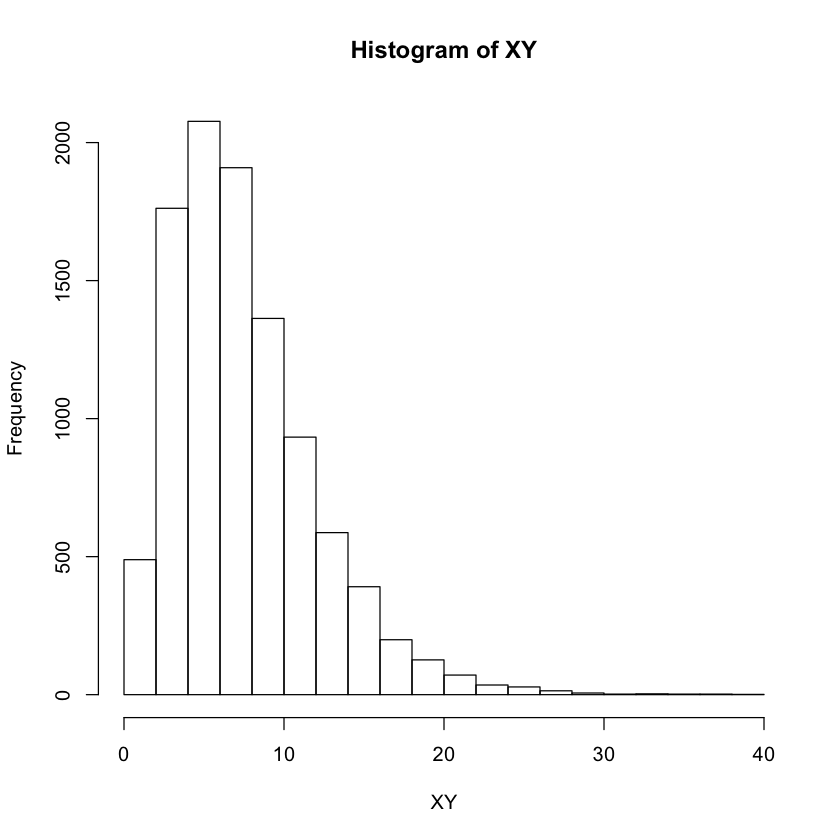

In [18]:
boot.iter <- 10000
XY <- numeric(boot.iter)

set.seed(613)
for (i in 1:boot.iter) {
    x <- rnorm(n = 1, mean = 10, sd = 1)
    y <- rgamma(n = 1, shape = 3, rate = 4)
    XY[i] <- x * y
}
print(quantile(x = XY, probs = c(0.025,0.5,0.975)))
hist(XY, breaks = 20)

### Example 2

##### Once I came across a paper that calculated the ratio of odds ratios ("ROR") of two variables, and claimed that the variable with bigger odds ratio (ROR$>1$) had a greater effect.

In [19]:
# Illustration of the idea on a different dataset.
stroke <- read.csv("https://raw.githubusercontent.com/ly129/EPIB613_2019/master/stroke.csv")
head(stroke)

,sex,dstr,age,coma,diab,minf,han,dead,obsmonths
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<dbl>
1,Male,1991-01-02,76,No,No,Yes,No,TRUE,0.16339869
2,Male,1991-01-03,58,No,No,No,No,FALSE,59.60784314
3,Male,1991-01-08,74,No,No,Yes,Yes,TRUE,4.73856209
4,Female,1991-01-11,78,No,Yes,No,Yes,TRUE,0.06535948
5,Female,1991-01-13,76,No,Yes,No,Yes,FALSE,59.28104575
6,Male,1991-01-13,48,Yes,No,No,Yes,TRUE,0.10000000


In [20]:
fit <- glm(dead~sex+diab+coma+minf, data = stroke, family = binomial())
print(exp(coef(fit)))

(Intercept)     sexMale     diabYes     comaYes     minfYes 
  1.2445152   0.5727227   1.3259460  70.2134665   2.7566108 


In [21]:
# ROR of myocardial infarction vs. diabetes
ROR_minf_diab <- exp(coef(fit))[5] / exp(coef(fit))[3]
ROR_minf_diab

minfYes 
2.078977

##### Let's pretend that the analysis is OK. We still need a confidence interval for this "ROR"...
- Statistically intractable.
    - $\mathrm{Var}(\beta_{minf}/\beta_{diab})$ cannot be calculated analytically.
    
- Solution? Bootstrap!

     2.5%       50%     97.5% 
0.9839096 2.1269956 4.1777443 


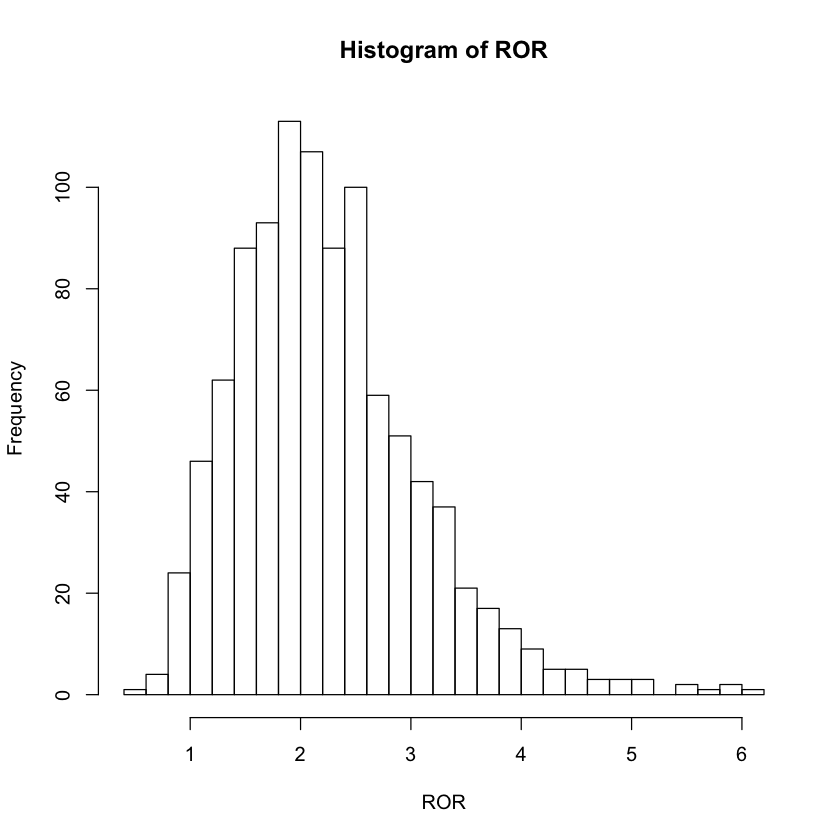

In [22]:
n <- nrow(stroke)
boot.iter <- 1000
ROR <- numeric(boot.iter)

set.seed(613)
for (i in 1:boot.iter) {
    boot.index <- sample(1:n, n, replace = T)
    boot.sample <- stroke[boot.index, ]
    fit <- glm(dead~sex+diab+coma+minf,
               data = boot.sample,
               family = binomial())
    ROR[i] <- exp(coef(fit))[5] / exp(coef(fit))[3]
}
print(quantile(x = ROR, probs = c(0.025,0.5,0.975)))
hist(ROR, breaks = 20)

In [23]:
library(boot)
# function to obtain the estimate of ROR
ROR <- function(data, indices) {
    # allows boot to select sample
    d <- data[indices,]
    fit <- glm(dead~sex+diab+coma+minf,
               data = d,
               family = binomial())
    ror <- exp(coef(fit))[5] / exp(coef(fit))[3]
    return(ror)
}
results <- boot(data = stroke, statistic = ROR, R = 1000)
results


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot::boot(data = stroke, statistic = ROR, R = 1000)


Bootstrap Statistics :
    original    bias    std. error
t1* 2.078977 0.1560756   0.8775112

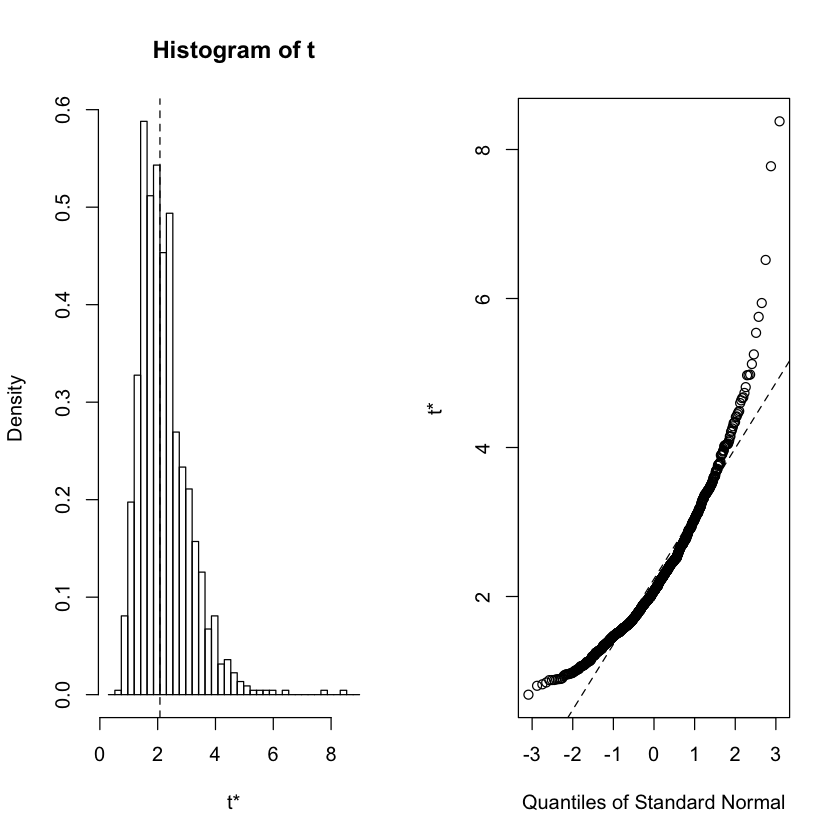

In [24]:
plot(results)

In [25]:
boot.ci(results)

Warning message in boot.ci(results):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = results)

Intervals : 
Level      Normal              Basic         
95%   ( 0.203,  3.643 )   (-0.167,  3.159 )  

Level     Percentile            BCa          
95%   ( 0.999,  4.325 )   ( 0.994,  4.310 )  
Calculations and Intervals on Original Scale